# QC

This is a notebook for implementing SNAP's Quality Control on the data products produced in this pipeline.

In [1]:
import os
import re
import rasterio
import threading
import concurrent.futures
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path
import itertools

input_dir = "/atlas_scratch/ALFRESCO/Runs/2023/GeoNetwork/input"
products_dir = "/atlas_scratch/ALFRESCO/Runs/2023/GeoNetwork/products"

variables = [
    'Flammability',
    'Vegetation_Percent',
    'Vegetation_Mode',
]

historical_fire_dir = input_dir + "/HistoricalFires"

models = [
    'GFDL-CM3',
    'GISS-E2-R',
    'IPSL-CM5A-LR',
    'MRI-CGCM3',
    'NCAR-CCSM4',
    '5ModelAvg',
]

scenarios = [
    'RCP45',
    'RCP60',
    'RCP85',
]

fmos = [
    'NoFMO',
    'FMO',
    'AltFMO',
]

## Metadata and tag checks

First, set up the function to read metadata from all GeoTIFFs in parallel:

In [2]:
def meta_and_tag_check(directory):
    all_meta = []
    all_tags = []
    fps = [x for x in directory.glob("*.tif")]
    read_lock = threading.Lock()

    def process(fp):
        src = rasterio.open(fp)
        with read_lock:
            profile = src.profile
            tags = src.tags()
            all_meta.append(profile)
            all_tags.append(tags)
    
    # We map the process() function over the list of files
    with concurrent.futures.ThreadPoolExecutor(
        max_workers=32
    ) as executor:
        executor.map(process, fps)

    return {
        "meta": all_meta,
        "tags": all_tags
    }

Run the metadata extraction for all GeoTIFF types (vegetation mode, vegetation percent, flammability) and all combinations of models and fire management options (FMO) scenarios:

In [3]:
meta = {}
tags = {}
for variable in variables:
    meta[variable] = []
    tags[variable] = []
    for model, scenario, fmo in itertools.product(models, scenarios, fmos):
        msf = model + "_" + scenario + "_" + fmo
        path = products_dir + "/ALFRESCO_" + variable + "_" + msf + "_2015-2100"
        meta_and_tags = meta_and_tag_check(Path(path))
        meta[variable] += meta_and_tags["meta"]
        tags[variable] += meta_and_tags["tags"]

    path = products_dir + "/ALFRESCO_" + variable + "_CRU_TS40_Historical_1901-2014"
    meta_and_tags = meta_and_tag_check(Path(path))
    meta[variable] += meta_and_tags["meta"]
    tags[variable] += meta_and_tags["tags"]
    

Take a look at the metadata for one GeoTIFF from each type of GeoTIFF:

In [4]:
for variable in variables:
    print("Metadata for " + variable + ":")
    print(meta[variable][0], end="\n\n")

Metadata for Flammability:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3650, 'height': 2100, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(1000.0, 0.0, -1725223.205807,
       0.0, -1000.0, 2544412.932644), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

Metadata for Vegetation_Percent:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3650, 'height': 2100, 'count': 9, 'crs': CRS.from_epsg(3338), 'transform': Affine(1000.0, 0.0, -1725223.205807,
       0.0, -1000.0, 2544412.932644), 'tiled': False, 'compress': 'lzw', 'interleave': 'pixel'}

Metadata for Vegetation_Mode:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 3650, 'height': 2100, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(1000.0, 0.0, -1725223.205807,
       0.0, -1000.0, 2544412.932644), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}



Observe from the output above that each type of GeoTIFF (vegetation mode, vegetation percent, flammability) has slightly different metadata. Vegetation mode uses the `uint8` data type whereas the others use `float32`. Vegetation percent has 9 bands whereas the others have 1 band. We can verify that all GeoTIFFs in each series has the same metadata as long as we only compare between GeoTIFFs of the same type. Let's do this now:

In [5]:
for variable in variables:
    assert(all([dict(x) == meta[variable][0] for x in meta[variable]]) == True)

If the above assertion returns no errors, we have confirmed that all GeoTIFFs share the same metadata with other GeoTIFFs of the same type.

Next, let's take a look at the GeoTIFF tags:

In [6]:
for variable in variables:
    print("Tags for " + variable + ":")
    print(tags[variable][0], end="\n\n")

Tags for Flammability:
{'AREA_OR_POINT': 'Area', 'TIFFTAG_IMAGEDESCRIPTION': 'Values represent flammability.', 'TIFFTAG_SOFTWARE': 'ALFRESCO 2.2.1 from UAF.'}

Tags for Vegetation_Percent:
{'AREA_OR_POINT': 'Area', 'TIFFTAG_IMAGEDESCRIPTION': 'Values represent percentage of vegetation type. Band Index: 1=NoVeg, 2=Black Spruce, 3=White Spruce, 4=Deciduous, 5=Shrub Tundra, 6=Graminoid Tundra, 7=Wetland Tundra, 8=Barren/Lichen/Moss, 9=Temperate Rainforest', 'TIFFTAG_SOFTWARE': 'ALFRESCO 2.2.1 from UAF.'}

Tags for Vegetation_Mode:
{'AREA_OR_POINT': 'Area', 'TIFFTAG_IMAGEDESCRIPTION': 'Value Index: 0=NoVeg, 1=Black Spruce, 2=White Spruce, 3=Deciduous, 4=Shrub Tundra, 5=Graminoid Tundra, 6=Wetland Tundra, 7=Barren/Lichen/Moss, 8=Temperate Rainforest', 'TIFFTAG_SOFTWARE': 'ALFRESCO 2.2.1 from UAF.'}



Observe that the `TIFFTAG_IMAGEDESCRIPTION` and `TIFFTAG_SOFTWARE` tags are being used to communicate important information about these GeoTIFFs, including:

- the version of ALFRESCO that was used to generated the GeoTIFFs
- what the values represent
- the value index for vegetation mode GeoTIFFs
- the band index for vegetation percent GeoTIFFs

Now let's confirm that all GeoTIFFs of similar types share the same tags, similar to what we did for the metadata earlier:

In [7]:
for variable in variables:
    assert(all([dict(x) == tags[variable][0] for x in tags[variable]]) == True)

## Declare common data check functions

These functions will be used throughout the rest of the notebook to analyze each type of GeoTIFF (vegetation mode, vegetation percent, flammability).

The `get_geotiff_series` function will be used to get a set of GeoTIFFs corresponding to the provided years. Informaton about the GeoTIFF's year and model & FMO scenario combination are bundled with the file path for use in plot titles. The `get_stat_summary_from_raster_list` function calculates the min, max, and mean of a raster array to be used in some sanity checks.

In [8]:
def get_geotiff_series(msf, variable, range="2015-2100", years=['2050', '2075', '2100']):
    path = products_dir + "/ALFRESCO_" + variable + "_" + msf + "_" + range
    msf_dir = Path(path)
    fps = []
    for year in years:
        for file in msf_dir.glob("*{}*.tif".format(year)):
            fps.append({
                'title': msf,
                'year': year,
                'tif': file
            })
    return fps


def get_stat_summary_from_raster_list(rstrs, band=1, precision=1):
    di = {}
    for rstr_dict in rstrs:
        fp = rstr_dict["tif"]
        fp_key = fp.name[:-4] + " Band " + str(band)
        di[fp_key] = {}
        with rasterio.open(fp) as src:
            arr = src.read(band).astype(float)
            arr[arr == src.nodata] = np.nan
            di[fp_key]["arr"] = arr
            di[fp_key]["min"] = np.round(np.nanmin(arr), precision)
            di[fp_key]["max"] = np.round(np.nanmax(arr), precision)
            di[fp_key]["mean"] = np.round(np.nanmean(arr), precision)
    return di

## Vegetation mode data checks

In [9]:
mode_sample = []
for model in models:
    msf = model + "_RCP85_NoFMO"
    path = products_dir + "/ALFRESCO_Vegetation_Mode_" + msf + "_2015-2100"
    mode_sample += get_geotiff_series(msf, "Vegetation_Mode")

In [10]:
mode_sample_di = get_stat_summary_from_raster_list(mode_sample)
mode_sample_di

{'Mode_Vegetation_2050 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ...,  8.,  8.,  8.],
         [nan, nan, nan, ...,  8.,  8.,  8.],
         [nan, nan, nan, ...,  8.,  8.,  8.]]),
  'min': 0.0,
  'max': 8.0,
  'mean': 2.9},
 'Mode_Vegetation_2075 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ...,  8.,  8.,  8.],
         [nan, nan, nan, ...,  8.,  8.,  8.],
         [nan, nan, nan, ...,  8.,  8.,  8.]]),
  'min': 0.0,
  'max': 8.0,
  'mean': 3.0},
 'Mode_Vegetation_2100 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ...,  8.,  8.,  8.],
         [nan, n

Possible values for the vegetation mode GeoTIFFs are 0-8, with a nodata value of 255. The data skews heavily towards the 0-4 range, however, so we should expect the mean to be below 5. Let's check this.

In [11]:
for k in mode_sample_di.keys():
    assert(mode_sample_di[k]["min"] == 0)
    assert(mode_sample_di[k]["max"] == 8)
    assert(mode_sample_di[k]["mean"] < 5)

If the assertions above returned no error, the data passed the first check! Next, let's define a function that converts a Rasterio color map into a Matplotlib-compatible color map so the vegetation mode plots in this notebook use the same color map that is encoded into the GeoTIFFs.

In [12]:
def convert_colormap(rasterio_cmap):
    matplotlib_cmap = []
    cmap_values = list(rasterio_cmap.values())
    for values in cmap_values:
        # Convert integers to decimal color representations
        value_list = map(lambda x: x / 255, list(values))
        matplotlib_cmap.append(list(value_list))
    return ListedColormap(matplotlib_cmap[0:8])

Now let's plot each vegetation mode GeoTIFF from our sample. These include GeoTIFFs from each model (+ 5 model average) for the years 2050, 2075, and 2100.

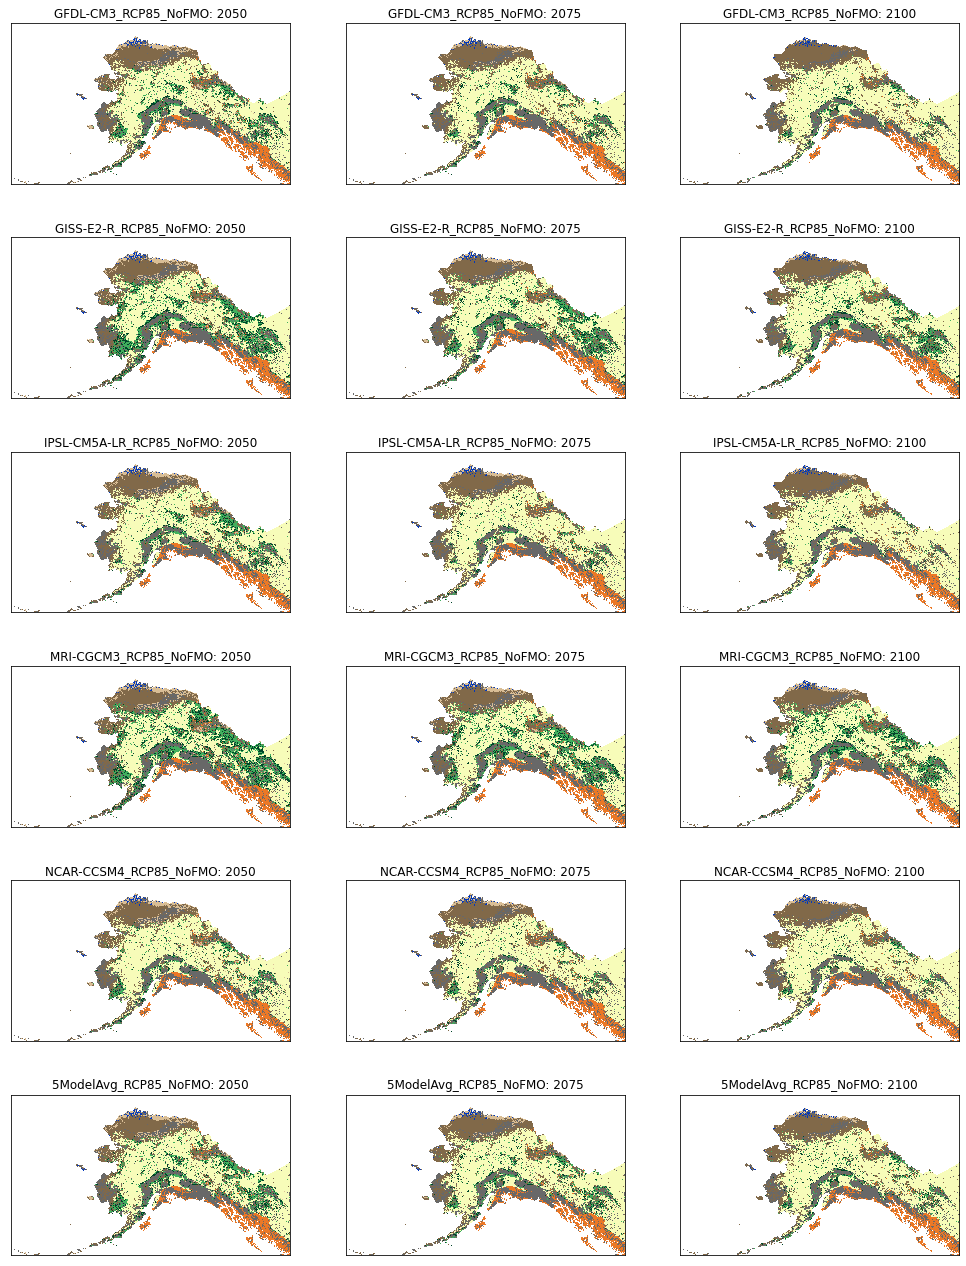

In [13]:
fig, axs = plt.subplots(6, 3, figsize=(17, 23), sharex=True, sharey=True)
fig.patch.set_facecolor("white")
for ax, fp in zip(axs.flatten(), mode_sample):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    with rasterio.open(fp["tif"]) as src:
        arr = src.read(1).astype(float)
        arr[arr == src.nodata] = np.nan
        cmap = convert_colormap(src.colormap(1))
        ax.imshow(arr, cmap=cmap, interpolation="none")
        ax.set_title(fp["title"] + ": " + fp["year"])

The differences are fairly suble, but looking closely, we can see differences between the models and years along the northern coast and interior.

Next, let's take a look at a few historical fire input GeoTIFFs vs. vegetation mode GeoTIFFs for the subsequent years.

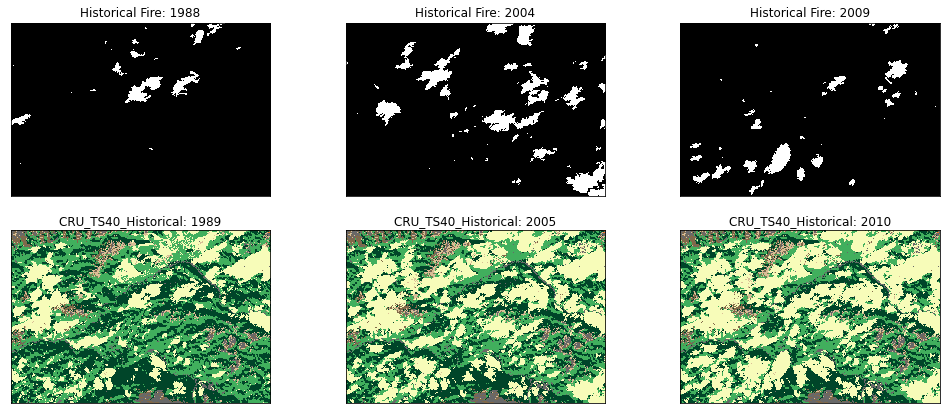

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(17, 7), sharex=True, sharey=True)
fig.patch.set_facecolor("white")

historical_fires = []
historical_fire_years = ['1988', '2004', '2009']
for year in historical_fire_years:   
    historical_fires.append({
        "tif": historical_fire_dir + "/AlaskaFireHistory_{}.tif".format(year),
        "year": year,
        "title": "Historical Fire"
    })

veg_mode_years = map(lambda x: str(int(x) + 1), historical_fire_years)
msf = "CRU_TS40_Historical"
fire_scars = get_geotiff_series(msf, "Vegetation_Mode", range="1901-2014", years=veg_mode_years)
comparisons = historical_fires + fire_scars

for ax, fp in zip(axs.flatten(), comparisons):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    with rasterio.open(fp["tif"]) as src:
        arr = src.read(1).astype(float)
        arr[arr == src.nodata] = np.nan

        try:
            cmap = convert_colormap(src.colormap(1))
        except:
            cmap = "binary_r"

        ax.imshow(arr[600:1000, 1700:2300], cmap=cmap, interpolation="none")
        ax.set_title(fp["title"] + ": " + fp["year"])

Observe that the shapes of the historical fires show up as splotches of deciduous forest the next year.

Next, since the differences between the 5 individual models and 5 model average are so subtle, let's check the vegetation mode value of an arbitrary pixel for several years.

In [15]:
for year in ['2025', '2050', '2075', '2100']:
    print(year + ":")
    mode_sample = []
    for model in models:
        msf = model + "_RCP85_NoFMO"
        mode_sample += get_geotiff_series(msf, "Vegetation_Mode", years=[year])

    for fp in mode_sample:
        with rasterio.open(fp["tif"]) as src:
            arr = src.read(1).astype(int)
            pixel_value = arr[500, 1800]
            print(fp["title"] + ": " + str(pixel_value))
    print("")

2025:
GFDL-CM3_RCP85_NoFMO: 5
GISS-E2-R_RCP85_NoFMO: 5
IPSL-CM5A-LR_RCP85_NoFMO: 5
MRI-CGCM3_RCP85_NoFMO: 5
NCAR-CCSM4_RCP85_NoFMO: 5
5ModelAvg_RCP85_NoFMO: 5

2050:
GFDL-CM3_RCP85_NoFMO: 4
GISS-E2-R_RCP85_NoFMO: 5
IPSL-CM5A-LR_RCP85_NoFMO: 5
MRI-CGCM3_RCP85_NoFMO: 5
NCAR-CCSM4_RCP85_NoFMO: 5
5ModelAvg_RCP85_NoFMO: 5

2075:
GFDL-CM3_RCP85_NoFMO: 4
GISS-E2-R_RCP85_NoFMO: 4
IPSL-CM5A-LR_RCP85_NoFMO: 4
MRI-CGCM3_RCP85_NoFMO: 4
NCAR-CCSM4_RCP85_NoFMO: 4
5ModelAvg_RCP85_NoFMO: 4

2100:
GFDL-CM3_RCP85_NoFMO: 4
GISS-E2-R_RCP85_NoFMO: 4
IPSL-CM5A-LR_RCP85_NoFMO: 4
MRI-CGCM3_RCP85_NoFMO: 4
NCAR-CCSM4_RCP85_NoFMO: 4
5ModelAvg_RCP85_NoFMO: 4



This looks sane! The vegetation mode for the 5-model-average was computed by taking the mode of 1,000 replicates (200 replicates for each of the 5 models), not simply the mode of their modes, but the end result here is the same regardless.

## Vegetation percent data checks

Since the vegetation percent GeoTIFFs have 9 bands, let's look at all 9 bands of just one GeoTIFF.

In [16]:
percent_sample = []
for model, scenario, fmo in itertools.product(models, scenarios, fmos):
    msf = model + "_" + scenario + "_" + fmo
    percent_sample += get_geotiff_series(msf, "Vegetation_Percent", years=['2100'])

In [17]:
percent_sample_dis = []
for band in range(1, 10):
    percent_sample_dis.append(get_stat_summary_from_raster_list(percent_sample, band))
percent_sample_dis

[{'Percent_Vegetation_2100 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ...,  0.,  0.,  0.],
          [nan, nan, nan, ...,  0.,  0.,  0.],
          [nan, nan, nan, ...,  0.,  0.,  0.]]),
   'min': 0.0,
   'max': 100.0,
   'mean': 17.4}},
 {'Percent_Vegetation_2100 Band 2': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ...,  0.,  0.,  0.],
          [nan, nan, nan, ...,  0.,  0.,  0.],
          [nan, nan, nan, ...,  0.,  0.,  0.]]),
   'min': 0.0,
   'max': 100.0,
   'mean': 7.8}},
 {'Percent_Vegetation_2100 Band 3': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, n

Possible values for the vegetation percent GeoTIFFs are 0.0-100.0, with a nodata value of -9999. Generally we shouldn't expect the mean value for any vegetation percent GeoTIFF band to exceed ~70%, but this is more of a rule of thumb. Let's check it anyway because any mean higher than 70% should catch our attention.

In [18]:
for percent_sample_di in percent_sample_dis:
    for k in percent_sample_di.keys():
        assert(percent_sample_di[k]["min"] == 0.0)
        assert(percent_sample_di[k]["max"] == 100.0)
        assert(percent_sample_di[k]["mean"] < 70.0)

Next, let's plot each band from a single vegetation percent GeoTIFF.

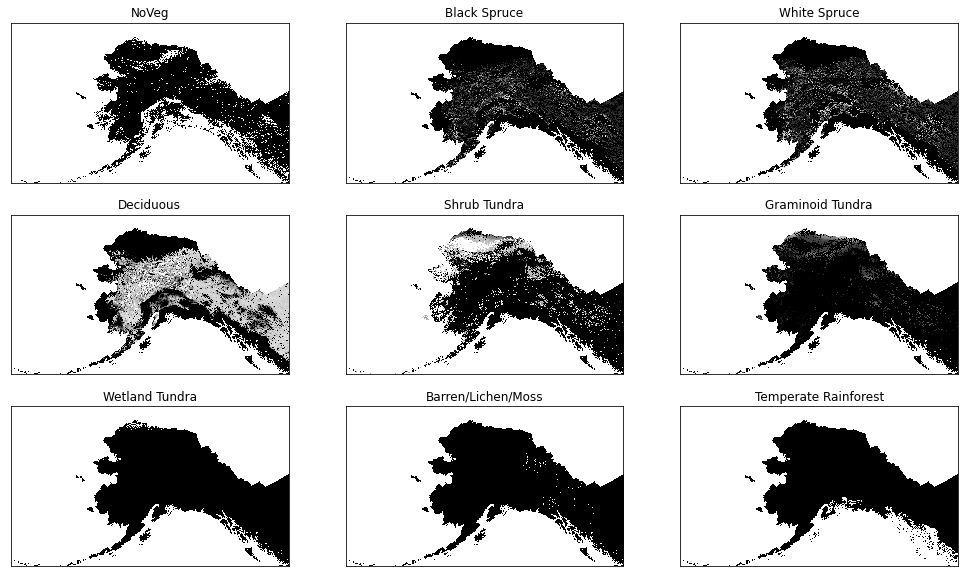

In [19]:
fig, axs = plt.subplots(3, 3, figsize=(17, 10), sharex=True, sharey=True)
fig.patch.set_facecolor("white")
last_year = percent_sample[-1]
bands = range(1, 10)
for ax, band in zip(axs.flatten(), bands):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    with rasterio.open(last_year["tif"]) as src:
        description = src.tags()["TIFFTAG_IMAGEDESCRIPTION"]
        matches = re.findall(r"([0-9]+)\=([\w/ ]+)", description)
        veg_bands = dict(matches)
        veg_bands = {int(k):v for k, v in veg_bands.items()}
        arr = src.read(band).astype(float)
        arr[arr == src.nodata] = np.nan
        ax.imshow(arr, cmap="gray", interpolation="none")
        ax.set_title(veg_bands[band])

Any pixel that shows as bright white in one plot should show as black in the others. Dark gray values can be evenly distributed between several plots. This all appears to be the case, so this passes the eyeball test. Also note how the title of each plot was taken from the band index of the `TIFFTAG_IMAGEDESCRIPTION` GeoTIFF tag, which means that tag is working as designed too!

Next up, let's test the 5 model average. The differences between each model are, again, fairly subtle and hard to see via an eyeball test. So, let's test an arbitrary pixel across several years to make sure the 5 model average truly represents the average of the 5 individual models.

In [20]:
for year in ['2025', '2050', '2075', '2100']:
    print(year + ":")
    percent_sample = []
    for model in models:
        msf = model + "_RCP85_FMO"
        percent_sample += get_geotiff_series(msf, "Vegetation_Percent", years=[year])

    sum = 0
    for fp in percent_sample:
        with rasterio.open(fp["tif"]) as src:
            arr = src.read(4).astype(float)
            pixel_value = arr[900, 1500]
            print(fp["title"] + ": " + str(round(pixel_value, 1)))
            if "5ModelAvg" not in fp["title"]:
                sum += pixel_value
    average = sum / 5
    print("Calculated 5-model average: " + str(average) + "\n")

2025:
GFDL-CM3_RCP85_FMO: 11.5
GISS-E2-R_RCP85_FMO: 8.5
IPSL-CM5A-LR_RCP85_FMO: 7.0
MRI-CGCM3_RCP85_FMO: 9.0
NCAR-CCSM4_RCP85_FMO: 7.0
5ModelAvg_RCP85_FMO: 8.6
Calculated 5-model average: 8.6

2050:
GFDL-CM3_RCP85_FMO: 20.0
GISS-E2-R_RCP85_FMO: 4.5
IPSL-CM5A-LR_RCP85_FMO: 89.0
MRI-CGCM3_RCP85_FMO: 5.0
NCAR-CCSM4_RCP85_FMO: 16.0
5ModelAvg_RCP85_FMO: 26.9
Calculated 5-model average: 26.9

2075:
GFDL-CM3_RCP85_FMO: 67.5
GISS-E2-R_RCP85_FMO: 43.0
IPSL-CM5A-LR_RCP85_FMO: 92.5
MRI-CGCM3_RCP85_FMO: 5.0
NCAR-CCSM4_RCP85_FMO: 87.0
5ModelAvg_RCP85_FMO: 59.0
Calculated 5-model average: 59.0

2100:
GFDL-CM3_RCP85_FMO: 76.5
GISS-E2-R_RCP85_FMO: 75.5
IPSL-CM5A-LR_RCP85_FMO: 91.5
MRI-CGCM3_RCP85_FMO: 5.5
NCAR-CCSM4_RCP85_FMO: 90.5
5ModelAvg_RCP85_FMO: 67.9
Calculated 5-model average: 67.9



## Flammability data checks

In [21]:
flammability_sample = []
for model in models:
    msf = "CRU_TS40_Historical"
    flammability_sample += get_geotiff_series(msf, "Flammability", range="1901-2014", years=['1940', '2004'])
    msf = model + "_RCP85_AltFMO"
    flammability_sample += get_geotiff_series(msf, "Flammability", years=['2025'])

In [22]:
flammability_sample_di = get_stat_summary_from_raster_list(flammability_sample, 1, 5)
flammability_sample_di

{'Flammability_1940 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.]]),
  'min': 0.0,
  'max': 0.21,
  'mean': 0.00682},
 'Flammability_2004 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.]]),
  'min': 0.0,
  'max': 1.0,
  'mean': 0.01063},
 'Flammability_2025 Band 1': {'arr': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, n

Possible values for the flammability GeoTIFFs are 0.0 - 1.0, with a nodata value of -9999. The value for each pixel represents the number of times that pixel showed as an active fire across all 200 ALFRESCO replicates, divided by 200.

We would normally expect values to be much closer to 0.0 than 1.0, but you'll notice that the data for 2004 has a max value of 1.0. This is because all years from 1950 - 2021 are using historical fire GeoTIFFs for the flammability calculation, so from 1950-2021 all 200 replicates showed the pixel as having a fire, and the average value for that pixel is 1.0.

Let's run some assertions based on the above understandings.

In [23]:
for k in flammability_sample_di.keys():
    assert(flammability_sample_di[k]["min"] == 0.0)
    assert(flammability_sample_di[k]["max"] <= 1.0)
    assert(flammability_sample_di[k]["mean"] < 0.1)

And finally, show some plots of historical vs. projected flammability, including a plot from each individual model and the 5 model average.

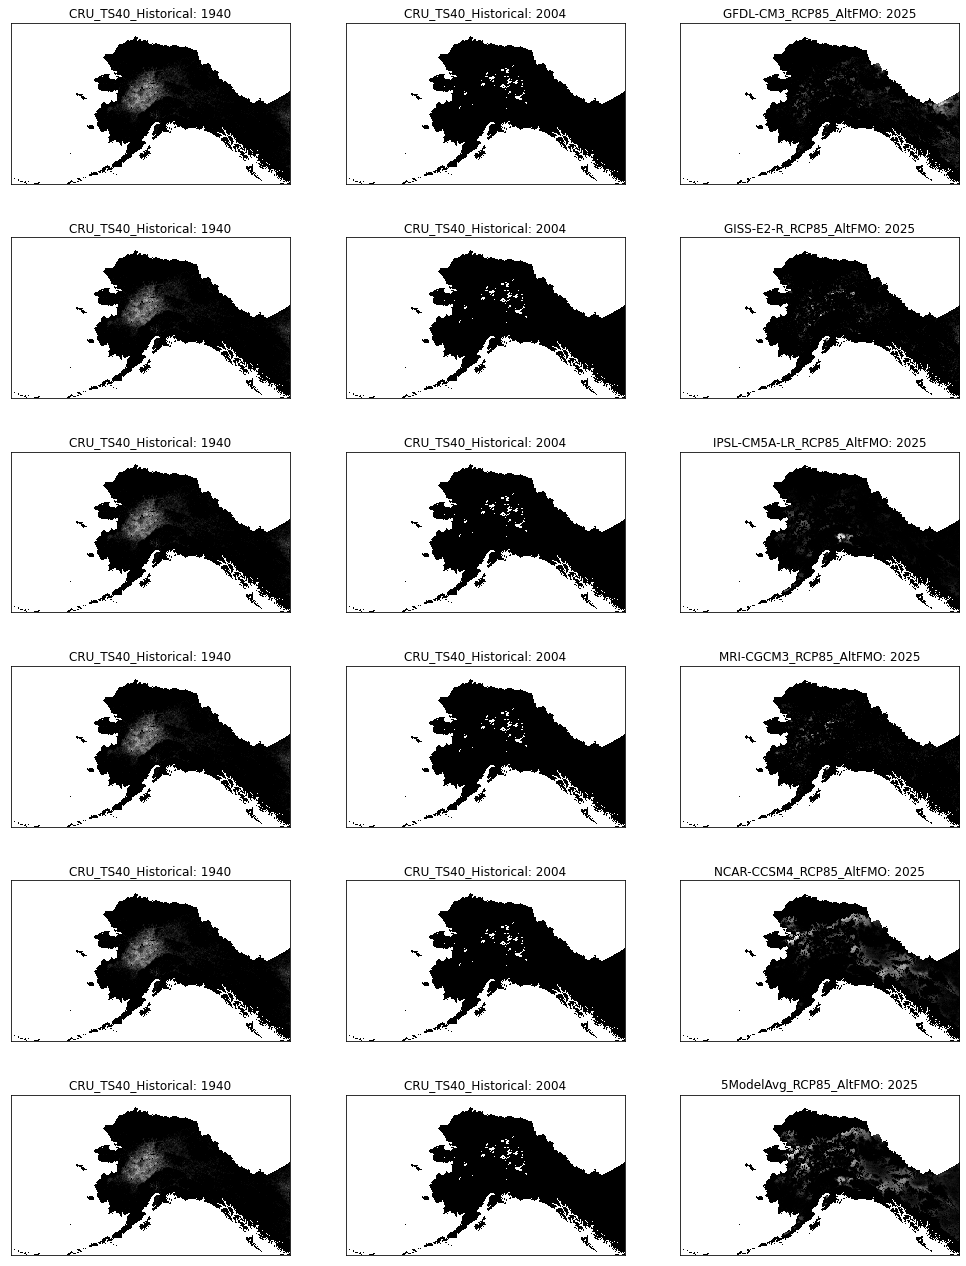

In [24]:
fig, axs = plt.subplots(6, 3, figsize=(17, 23), sharex=True, sharey=True)
fig.patch.set_facecolor("white")
for ax, fp in zip(axs.flatten(), flammability_sample):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    with rasterio.open(fp["tif"]) as src:
        arr = src.read(1).astype(float)
        arr[arr == src.nodata] = np.nan
        ax.imshow(arr, cmap="gray", interpolation="none")
        ax.set_title(fp["title"] + ": " + fp["year"])

The plots for 1940 and 2004 are the same between models and are repeated to be clear that they are part of the time series of each model. Each ALFRESCO run shares the same historical climate inputs and fire polygons until 2014, so the GeoTIFFs do not start to diverge until 2015.

Notice the variation between the 2025 plots. There is substantial variation between the flammability of the individual models, and the 5 model average does indeed appear to be the average of each of the individual models for 2025.

Finally, let's look at an individual pixel across several years for all 5 models and the 5 model average to verify that the average looks correct.

In [25]:
for year in ['2025', '2050', '2075', '2100']:
    print(year + ":")
    flammability_sample = []
    for model in models:
        msf = model + "_RCP85_AltFMO"
        flammability_sample += get_geotiff_series(msf, "Flammability", years=[year])

    sum = 0
    for fp in flammability_sample:
        with rasterio.open(fp["tif"]) as src:
            arr = src.read(1).astype(float)
            pixel_value = arr[1100, 1500]
            print(fp["title"] + ": " + str(round(pixel_value, 3)))
            if "5ModelAvg" not in fp["title"]:
                sum += pixel_value
    average = sum / 5
    print("Calculated 5-model average: " + str(round(average, 3)) + "\n")

2025:
GFDL-CM3_RCP85_AltFMO: 0.0
GISS-E2-R_RCP85_AltFMO: 0.0
IPSL-CM5A-LR_RCP85_AltFMO: 0.0
MRI-CGCM3_RCP85_AltFMO: 0.0
NCAR-CCSM4_RCP85_AltFMO: 0.0
5ModelAvg_RCP85_AltFMO: 0.0
Calculated 5-model average: 0.0

2050:
GFDL-CM3_RCP85_AltFMO: 0.0
GISS-E2-R_RCP85_AltFMO: 0.0
IPSL-CM5A-LR_RCP85_AltFMO: 0.0
MRI-CGCM3_RCP85_AltFMO: 0.0
NCAR-CCSM4_RCP85_AltFMO: 0.0
5ModelAvg_RCP85_AltFMO: 0.0
Calculated 5-model average: 0.0

2075:
GFDL-CM3_RCP85_AltFMO: 0.005
GISS-E2-R_RCP85_AltFMO: 0.005
IPSL-CM5A-LR_RCP85_AltFMO: 0.0
MRI-CGCM3_RCP85_AltFMO: 0.005
NCAR-CCSM4_RCP85_AltFMO: 0.015
5ModelAvg_RCP85_AltFMO: 0.006
Calculated 5-model average: 0.006

2100:
GFDL-CM3_RCP85_AltFMO: 0.005
GISS-E2-R_RCP85_AltFMO: 0.01
IPSL-CM5A-LR_RCP85_AltFMO: 0.02
MRI-CGCM3_RCP85_AltFMO: 0.02
NCAR-CCSM4_RCP85_AltFMO: 0.015
5ModelAvg_RCP85_AltFMO: 0.014
Calculated 5-model average: 0.014



This looks correct!